# Axora: Clinical Document Classification  
## Notebook 3: Unsupervised Clustering Analysis

---

## 🔹 Executive Summary
This notebook is the **third stage** of the project, focusing on **unsupervised learning**.  
Here, we apply clustering techniques to discover hidden patterns in the clinical documents, independent of their labeled specialties.

## 📌 Purpose of this Notebook
- Apply **k-Means clustering** on TF–IDF features of the documents.  
- Experiment with different values of *k* to identify meaningful clusters.  
- Analyze clusters by examining top keywords and their alignment with medical specialties.  
- Generate insights into potential **sub-specialties or common procedures** across documents.  

This stage complements the classification model by uncovering additional structure in the data, offering new insights for MedArchive Solutions.


## Importing Libraries
In this step, we import all the essential Python libraries required for clustering analysis:  

- *NumPy & Pandas* → For numerical computations and structured data handling.  
- *Matplotlib* → For creating visualizations (e.g., elbow plots, scatter plots).  
- *Hugging Face Datasets* → To load the medical transcriptions dataset directly from Hugging Face.  
- *Scikit-learn modules*:  
  - TfidfVectorizer → Converts clinical text into numerical features.  
  - KMeans → The clustering algorithm used to group documents.  
  - silhouette_score → To evaluate the quality of clustering.  
  - TruncatedSVD → For dimensionality reduction and 2D visualization of clusters.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import TruncatedSVD


c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Loading the Dataset
We use the Hugging Face dataset **hpe-ai/medical-cases-classification-tutorial**, which contains 2,460 anonymized clinical transcriptions labeled by medical specialty.  

- The dataset is pre-split into *train (1,720), **validation (370), and **test (370)* sets.  
- For clustering, we *combine all splits* into one DataFrame (df) since clustering does not require labels.  
- We then preview the dataset size and the first few rows to confirm successful loading.

In [2]:
# 1. Load Dataset
dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial")

# Convert to DataFrame
df_train = pd.DataFrame(dataset['train'])
df_val   = pd.DataFrame(dataset['validation'])
df_test  = pd.DataFrame(dataset['test'])
df = pd.concat([df_train, df_val, df_test], ignore_index=True)

print("Dataset size:", df.shape)
df.head()

Repo card metadata block was not found. Setting CardData to empty.


Dataset size: (2464, 5)


,description,transcription,sample_name,medical_specialty,keywords
0,Pacemaker ICD interrogation. Severe nonischem...,"PROCEDURE NOTE: , Pacemaker ICD interrogation....",Pacemaker Interrogation,Cardiovascular / Pulmonary,"cardiovascular / pulmonary, cardiomyopathy, ve..."
1,"Erythema of the right knee and leg, possible s...","PREOPERATIVE DIAGNOSES: , Erythema of the righ...",Aspiration - Knee Joint,Orthopedic,"orthopedic, knee and leg, anterolateral portal..."
2,Left cardiac catheterization with selective ri...,"PREOPERATIVE DIAGNOSIS: , Post infarct angina....",Cardiac Cath & Selective Coronary Angiography,Cardiovascular / Pulmonary,"cardiovascular / pulmonary, selective, angiogr..."
3,Patient with a history of coronary artery dise...,"REASON FOR VISIT: , Acute kidney failure.,HIST...",Acute Kidney Failure,Nephrology,None
4,Cardiac evaluation and treatment in a patient ...,"REASON FOR REFERRAL: , Cardiac evaluation and ...",Cardiac Consultation - 6,Cardiovascular / Pulmonary,None


## Step 2: Data Preparation
We load the hpe-ai/medical-cases-classification-tutorial dataset, which contains 
medical transcriptions along with their specialty labels.  

For clustering, we **exclude the medical_specialty column** because clustering is unsupervised.  
We only use the text transcriptions.


In [3]:
# 2. Extract raw text (transcriptions)
texts = df["transcription"].astype(str).tolist()

# 3. TF-IDF Vectorization
vectorizer = TfidfVectorizer(
    stop_words="english",
    lowercase=True,
    ngram_range=(1,2),   # unigrams + bigrams
    max_features=20000
)
X_tfidf = vectorizer.fit_transform(texts)
print("TF-IDF shape:", X_tfidf.shape)

TF-IDF shape: (2464, 20000)


## Step 3: TF-IDF Vectorization
We use *TF-IDF* to convert text into numerical vectors.  
Key configuration choices:
- lowercase=True: normalize text.
- stop_words="english": remove common words.
- ngram_range=(1,2): include both single words and two-word phrases.
- max_features=20000: limit vocabulary size for efficiency.

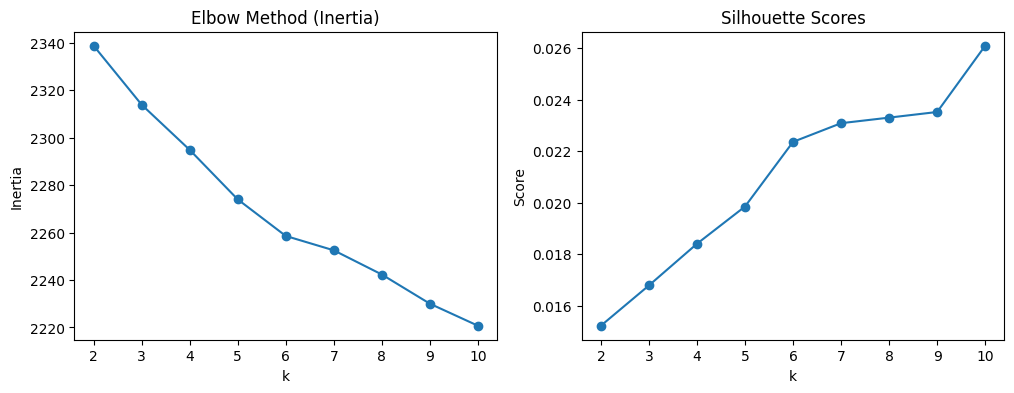

Best k by silhouette: 10


In [4]:
# 4. Elbow Method & Silhouette Scores to find best k
inertias, silhouettes, ks = [], [], range(2, 11)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_tfidf)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_tfidf, labels))

# Plot results
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(list(ks), inertias, marker="o")
plt.title("Elbow Method (Inertia)")
plt.xlabel("k"); plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(list(ks), silhouettes, marker="o")
plt.title("Silhouette Scores")
plt.xlabel("k"); plt.ylabel("Score")

plt.show()

best_k = list(ks)[np.argmax(silhouettes)]
print("Best k by silhouette:", best_k)

## Step 4: Choosing the Optimal Number of Clusters
We use two methods:
- *Elbow Method (Inertia)* → checks how within-cluster variance decreases as k increases.
- *Silhouette Score* → measures how well-separated clusters are.  

The best value of k is chosen from these plots (highest silhouette score, elbow “bend”).

In [5]:
# 5. Final KMeans Clustering
final_k = best_k
kmeans = KMeans(n_clusters=final_k, random_state=42, n_init=20)
labels = kmeans.fit_predict(X_tfidf)

df["cluster"] = labels
print("Cluster counts:")
print(df["cluster"].value_counts())

Cluster counts:
cluster
2    712
8    568
3    416
0    203
6    162
7    131
1     79
9     75
5     68
4     50
Name: count, dtype: int64


## Step 5: Final Clustering
We fit KMeans with the chosen k.  
Each transcription is assigned a cluster label.

In [6]:
# 6. Top terms per cluster
def top_terms_per_cluster(kmeans, vectorizer, n_terms=12):
    terms = vectorizer.get_feature_names_out()
    top_terms = {}
    for i, center in enumerate(kmeans.cluster_centers_):
        top_idx = center.argsort()[::-1][:n_terms]
        top_terms[i] = [terms[j] for j in top_idx]
    return top_terms

top_terms = top_terms_per_cluster(kmeans, vectorizer)

for cluster, terms in top_terms.items():
    print(f"\nCluster {cluster} top terms: {', '.join(terms)}")


Cluster 0 top terms: artery, coronary, left, right, coronary artery, aortic, valve, stenosis, catheter, right coronary, french, vessel

Cluster 1 top terms: c5, c6, c4, c5 c6, cervical, c4 c5, c3, c7, c6 c7, c3 c4, anterior, anterior cervical

Cluster 2 top terms: patient, placed, procedure, right, incision, left, using, anesthesia, removed, used, diagnosis, closed

Cluster 3 top terms: patient, right, pain, normal, history, fetal, left, discharge, exam, weeks, impression, spine

Cluster 4 top terms: l5, l4, l4 l5, s1, l5 s1, disc, lumbar, l3, nerve root, root, disk, nerve

Cluster 5 top terms: stress, heart rate, rate, heart, perfusion, exercise, beats, resting, test, minute, beats minute, myocardial perfusion

Cluster 6 top terms: lobe, procedure, upper lobe, scope, colon, upper, right, normal, bronchoscope, patient, biopsies, esophagus

Cluster 7 top terms: unremarkable, revealed, 93, exam, left, right, weakness, 95, 96, mri, 92, cn

Cluster 8 top terms: history, patient, mg, daily

## Step 6: Cluster Interpretation
For each cluster, we extract the *top TF-IDF terms* that define it.  
These terms help us understand whether the cluster corresponds to areas like:
- Surgical Procedures  
- Diagnostic Imaging  
- Patient Consultations  
- Medications & Treatments

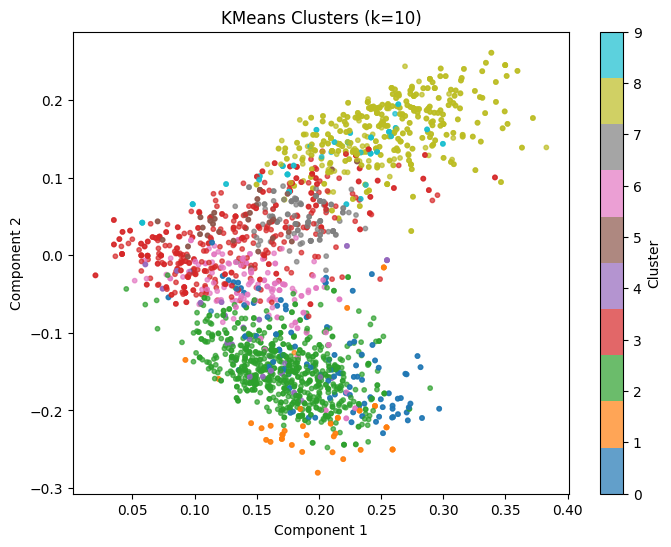

In [7]:
# 7. Visualization with TruncatedSVD (2D reduction)
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_tfidf)

plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels, cmap="tab10", s=10, alpha=0.7)
plt.title(f"KMeans Clusters (k={final_k})")
plt.xlabel("Component 1"); plt.ylabel("Component 2")
plt.colorbar(label="Cluster")
plt.show()

## Step 7: Visualizing Clusters
We reduce the high-dimensional TF-IDF vectors to *2D with TruncatedSVD* and plot clusters.  
This gives a visual sense of how well-separated the document groups are.

In [8]:
# 8. Show sample documents per cluster
for cluster in range(final_k):
    print("="*80)
    print(f"Cluster {cluster} (top terms: {', '.join(top_terms[cluster][:6])})")
    samples = df[df["cluster"] == cluster].sample(2, random_state=42)["transcription"].tolist()
    for s in samples:
        print("-"*60)
        print(s[:400], "...")

Cluster 0 (top terms: artery, coronary, left, right, coronary artery, aortic)
------------------------------------------------------------
1.  The left ventricular cavity size and wall thickness appear normal.  The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%.  There is near-cavity obliteration seen.  There also appears to be increased left ventricular outflow tract gradient at the mid cavity level consistent with hyperdynamic left ventricular systolic function ...
------------------------------------------------------------
PROCEDURES:,1.  Right and left heart catheterization.,2.  Coronary angiography.,3.  Left ventriculography.,PROCEDURE IN DETAIL:,  After informed consent was obtained, the patient was taken to the cardiac catheterization laboratory.  Patient was prepped and draped in sterile fashion.  Via modified Seldinger technique, the right femoral vein was punctured and a 6-French sheath was placed over a

## Step 8: Sample Documents per Cluster
We review sample transcriptions from each cluster alongside their top terms.  
This helps validate whether clusters correspond to *real-world medical themes*.

# 📊 Business Insights

The clustering results reveal hidden *sub-specialties and themes* in clinical transcriptions:

1. *Operational Efficiency*:  
   - Automatically discovered clusters can *pre-triage* documents into broad categories (e.g., “diagnostic imaging” vs. “surgeries”), reducing manual workload.  

2. *Quality Control*:  
   - Clusters may reveal *inconsistent documentation styles* or sub-specialty overlaps, useful for improving transcription guidelines.  

3. *Knowledge Discovery*:  
   - Identifying common co-occurring terms (e.g., “hip replacement,” “orthopedic surgery”) can help MedArchive Solutions *discover patterns* in patient cases.  

4. *Support for Classification*:  
   - Clusters can be used as *auxiliary features* for the supervised classifier (Notebook 2), potentially improving predictive accuracy.  

In short, clustering adds *business value* by providing a second layer of insights beyond direct specialty classification.